# Generating Music with GANs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")


CUDA is available


## Prerequisites

### Install dependencies

In [3]:
# !pip install --force-reinstall pypianoroll
!pip show pypianoroll 

!nvidia-smi

Name: pypianoroll
Version: 1.0.4
Summary: A toolkit for working with piano rolls
Home-page: UNKNOWN
Author: Hao-Wen Dong
Author-email: salu.hwdong@gmail.com
License: MIT
Location: /home/jjhaveri/.local/lib/python3.9/site-packages
Requires: matplotlib, pretty-midi, numpy, scipy
Required-by: muspy
Mon Jun 12 15:10:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   27C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+------------------------------

### Import libraries

In [3]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm.notebook import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

## Settings

In [4]:
# Data
n_tracks = 5  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 25, 33, 48]  # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
tempo = 100

# Training
batch_size = 16
latent_dim = 128
n_steps = 20000

# Sampling
sample_interval = 1000  # interval to run the sampler (in step)
n_samples = 4

In [5]:
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)
assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)    

## Data Prepration

### Download the Lakh Pianoroll Dataset (LPD)

In [7]:
!mkdir -p data

import gdown

# a file
url = "https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5"
output = "data/lpd_5_cleansed.tar.gz"
gdown.download(url, output, quiet=False)

url = "https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R"
output = "data/id_lists_amg.tar.gz"
gdown.download(url, output, quiet=False)

url = "https://drive.google.com/uc?id=1mpsoxU2fU1AjKopkcQ8Q8V6wYmVPbnPO"
output = "data/id_lists_lastfm.tar.gz"
gdown.download(url, output, quiet=False)

!tar zxf data/lpd_5_cleansed.tar.gz -C data/
!tar zxf data/id_lists_amg.tar.gz -C data/
!tar zxf data/id_lists_lastfm.tar.gz -C data/

Downloading...
From (uriginal): https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5
From (redirected): https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5&confirm=t&uuid=4cf18a32-fabe-478e-9a1b-1d76f19428d4
To: /home/jjhaveri/285/data/lpd_5_cleansed.tar.gz
100%|██████████| 555M/555M [00:14<00:00, 39.6MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R
To: /home/jjhaveri/285/data/id_lists_amg.tar.gz
100%|██████████| 63.9k/63.9k [00:00<00:00, 21.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mpsoxU2fU1AjKopkcQ8Q8V6wYmVPbnPO
To: /home/jjhaveri/285/data/id_lists_lastfm.tar.gz
100%|██████████| 668k/668k [00:00<00:00, 16.0MB/s]


^C


In [6]:
dataset_root = Path("data/lpd_5/lpd_5_cleansed/")
id_list = []
for path in os.listdir("data/amg"):
    filepath = os.path.join("data/amg", path)
    if os.path.isfile(filepath):
        with open(filepath) as f:
            id_list.extend([line.rstrip() for line in f])
id_list = list(set(id_list))

In [7]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

### Visualize an example of pianorolls in LPD

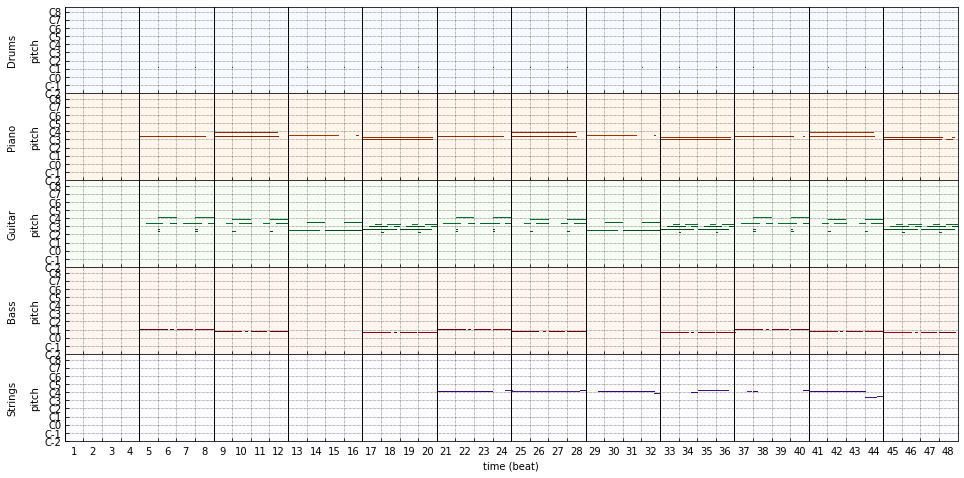

In [8]:
song_dir = dataset_root / msd_id_to_dirs('TREVDFX128E07859E0') # 'TRQAOWZ128F93000A4', 'TREVDFX128E07859E0'
multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
multitrack.trim(end=12 * 96)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(96, 12 * 96, 96):     
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

### Collect training data

In [9]:
data = []
# Iterate over all the songs in the ID list
for msd_id in tqdm(id_list):
    # Load the multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root / msd_id_to_dirs(msd_id)
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        data.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
print(f"Data shape : {data.shape}")

  0%|          | 0/7323 [00:00<?, ?it/s]

Successfully collect 26154 samples from 7323 songs
Data shape : (26154, 5, 64, 72)


### Visualize an example of training samples

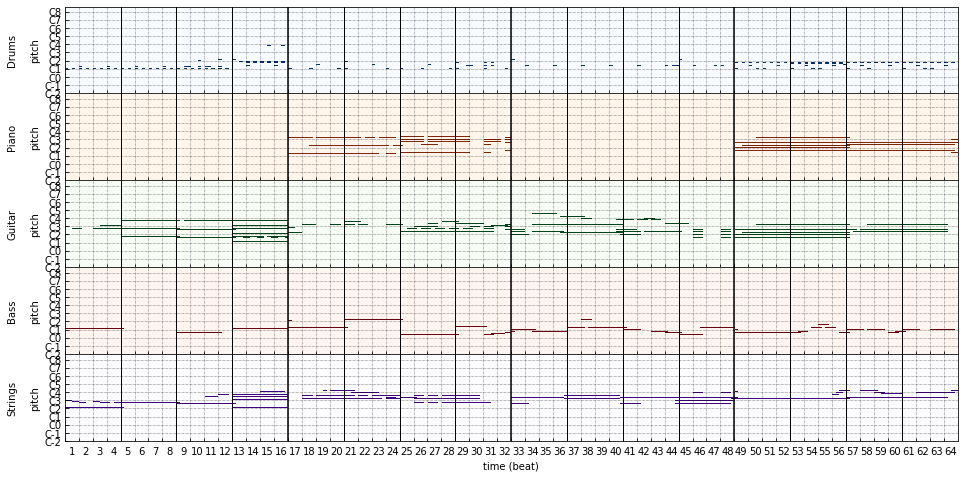

In [10]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(data[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

### Create dataset and data loader

In [11]:
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## Model

 ### Define the generator

In [12]:
# class GeneraterBlock(torch.nn.Module):
#     def __init__(self, in_dim, out_dim, kernel, stride):
#         super().__init__()
#         self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
#         self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
#     def forward(self, x):
#         x = self.transconv(x)
#         x = self.batchnorm(x)
#         return torch.nn.functional.relu(x)

In [13]:
class Generator(torch.nn.Module):
    """An LSTM based generator. The generator takes as input a latent vector and
    outputs a fake sample."""

    def __init__(self):
        super().__init__()
        self.num_layers = 3  # Number of LSTM layers
        self.hidden_size = 256  # Hidden size of each LSTM layer
        # Define the LSTM layers
        self.lstm = torch.nn.LSTM(latent_dim, hidden_size=self.hidden_size, num_layers=self.num_layers,
                                  batch_first=True, bidirectional= True)

        self.lstm2 = torch.nn.LSTM(self.hidden_size*2, hidden_size=self.hidden_size, num_layers=1, batch_first=True)

        # Calculate the input size for the linear layer based on LSTM configuration
        input_size = self.hidden_size
        input_size *= 2  # Multiply by 2 if bidirectional LSTM is used

        self.linear = torch.nn.Linear(int(input_size/2), n_tracks * n_measures * measure_resolution * n_pitches)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def forward(self, x):
        x = x.view(-1, 1, latent_dim)
        output, _ = self.lstm(x)
        output = torch.cat((output[:, -1, :self.hidden_size], output[:, 0, self.hidden_size:]), dim=1)
        output = output.unsqueeze(1)  # Add a dimension for the additional LSTM
        output, _ = self.lstm2(output)
        output = output.squeeze(1) 
        output = self.linear(output)
        output = output.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)

        return output


 ### Define the discriminator

In [14]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [15]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [16]:
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks)
        ])
        self.conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1)) for _ in range(n_tracks)
        ])
        self.conv2 = DiscriminatorBlock(16 * 5, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (2, 1, 1), (1, 1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (3, 1, 1), (3, 1, 1))
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, n_tracks, n_measures, measure_resolution, n_pitches)
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)          
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

## Training functions

In [17]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [18]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    # Transfer data to GPU
    if torch.cuda.is_available():
        
        real_samples = real_samples.cuda()
        latent = latent.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
#     print(real_samples.shape,"input to disc")
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
#     print(prediction_real.shape,"output from disc")
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
#     print(latent.shape,"input to gen")
    # Generate fake samples with the generator
    fake_samples = generator(latent)
#     print(fake_samples.shape,"output from gen ")
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## Training Preparation

In [19]:
# Create data loader
# data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print(Generator())
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create an empty dictionary to sotre history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0

Generator(
  (lstm): LSTM(128, 256, num_layers=3, batch_first=True, bidirectional=True)
  (lstm2): LSTM(512, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=23040, bias=True)
)
Number of parameters in G: 10654208
Number of parameters in D: 204321


## Training

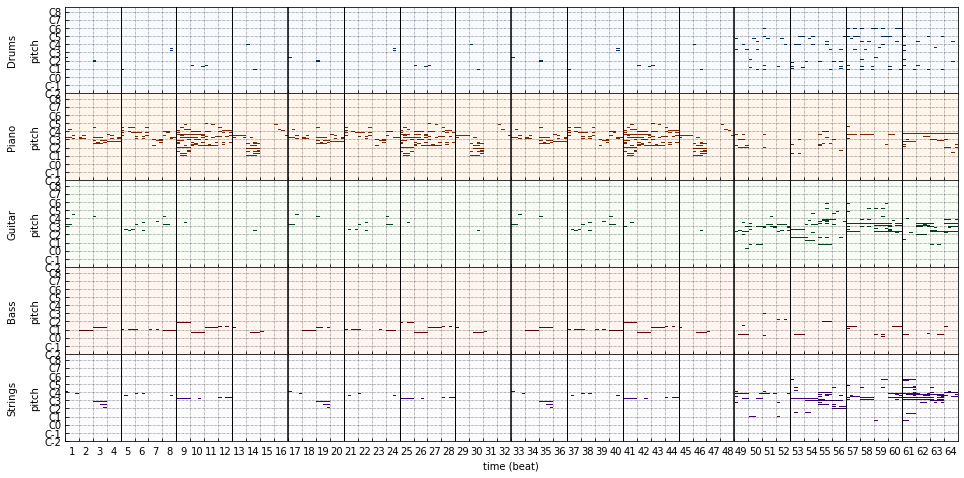

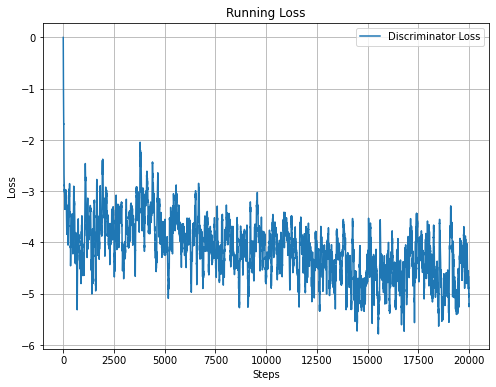

In [21]:
import matplotlib.pyplot as plt

step = 0
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

# Lists to store running loss values
running_d_loss_values = []
running_g_loss_values = []

final_d_loss = []
final_g_loss = []
import numpy as np

# Start iterations
while step < n_steps + 1:
    d_lossi = []
    g_lossi = []
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples[0])

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
#         print(running_d_loss.device,"andrew")
        if isinstance(running_d_loss, torch.Tensor):
            running_d_loss_values.append(running_d_loss.item())
            d_lossi = running_d_loss_values[-1]
        else:
            running_d_loss_values.append(running_d_loss)
            d_lossi = running_d_loss_values[-1]

        if isinstance(running_g_loss, torch.Tensor):
            running_g_loss_values.append(running_g_loss.item())
            g_lossi = running_g_loss_values[-1]
        else:
            running_g_loss_values.append(running_g_loss)
            g_lossi = running_g_loss_values[-1]

        # Update losses to progress bar
        progress_bar.set_description_str("(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))

        if step % sample_interval == 0:
            dict_to_save = {
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'generator_optimizer': g_optimizer.state_dict(),
                'discriminator_optimizer': d_optimizer.state_dict(),
                'running_d_loss': running_d_loss,
                'running_g_loss': running_g_loss
            }
            torch.save(dict_to_save, "newmodel_" + str(step) + ".pth")

            # Get generated samples
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()
            history_samples[step] = samples

            # Display loss curves
            clear_output(True)
#             if step > 0:
#                 liveloss.send()

            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
                pianoroll = np.pad(
                    samples[idx] > 0.5,
                    ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
                )
                tracks.append(
                    Track(
                        name=track_name,
                        program=program,
                        is_drum=is_drum,
                        pianoroll=pianoroll
                    )
                )
            m = Multitrack(
                tracks=tracks,
                tempo=tempo_array,
                resolution=beat_resolution
            )
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(
                    measure_resolution,
                    4 * measure_resolution * n_measures,
                    measure_resolution
                ):
                    if x % (measure_resolution * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.savefig("generated_samples_" + str(step) + ".png")
            plt.show()

            # Plot running loss values
            plt.figure(figsize=(8, 6))
            plt.plot(range(1, step + 2), running_d_loss_values, label='Discriminator Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Running Loss')
            plt.legend()
            plt.grid(True)
            plt.savefig(f'running_loss_plot_disc_{step}.png')

            plt.figure(figsize=(8, 6))
            plt.plot(range(1, step + 2), running_g_loss_values, label='Generator Loss')
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Running Loss')
            plt.legend()
            plt.grid(True)
            plt.savefig(f'running_loss_plot_gen_{step}.png')
 
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break
    plt.close()
    final_d_loss.append(np.mean(d_lossi))
    final_g_loss.append(np.mean(g_lossi))
    # Plot running loss values
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(final_d_loss)+1), final_d_loss, label='Discriminator Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Running Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'running_loss_plot_disc.png')
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(final_g_loss)+1), final_g_loss, label='Generator Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Running Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'running_loss_plot_gen.png')
    plt.close()

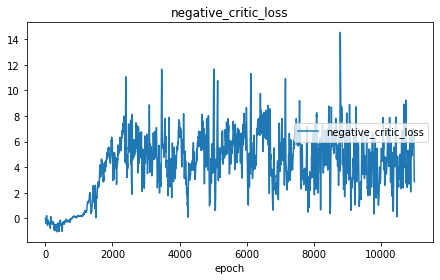

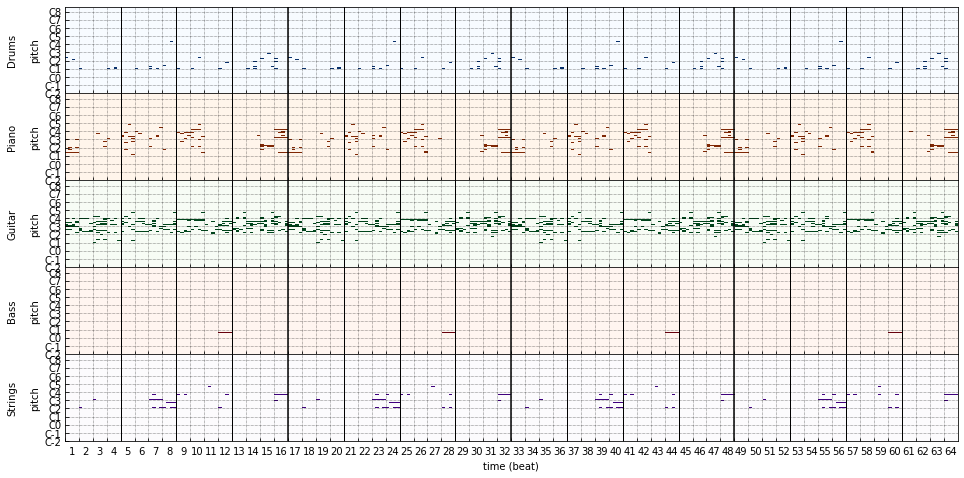

KeyboardInterrupt: 

In [21]:
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples[0])

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        if type(running_d_loss) == float:
          liveloss.update({'negative_critic_loss': -running_d_loss})
        else:
          liveloss.update({'negative_critic_loss': -running_d_loss.item()})
        # liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
        
        # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            dict_to_save = {
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'generator_optimizer': g_optimizer.state_dict(),
                'discriminator_optimizer': d_optimizer.state_dict()
            }
            torch.save(dict_to_save, "newmodel_"+str(step)+".pth")
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()
            history_samples[step] = samples

            # Display loss curves
            clear_output(True)
            if step > 0:
                liveloss.send()
            
            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(
                zip(programs, is_drums, track_names)
            ):
                pianoroll = np.pad(
                    samples[idx] > 0.5,
                    ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
                )
                tracks.append(
                    Track(
                        name=track_name,
                        program=program,
                        is_drum=is_drum,
                        pianoroll=pianoroll
                    )
                )
            m = Multitrack(
                tracks=tracks,
                tempo=tempo_array,
                resolution=beat_resolution
            )
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(
                    measure_resolution,
                    4 * measure_resolution * n_measures,
                    measure_resolution
                ):
                    if x % (measure_resolution * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.show()
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

## Training History

Step=0


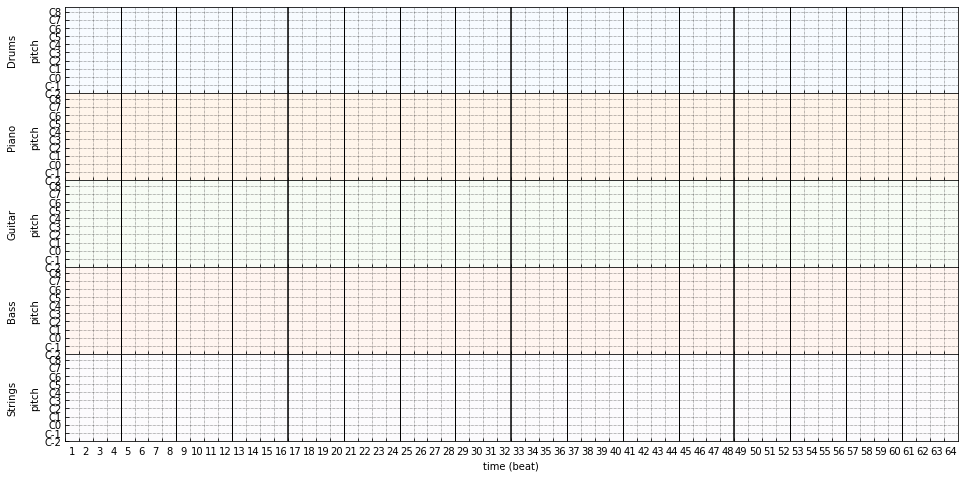

Step=100


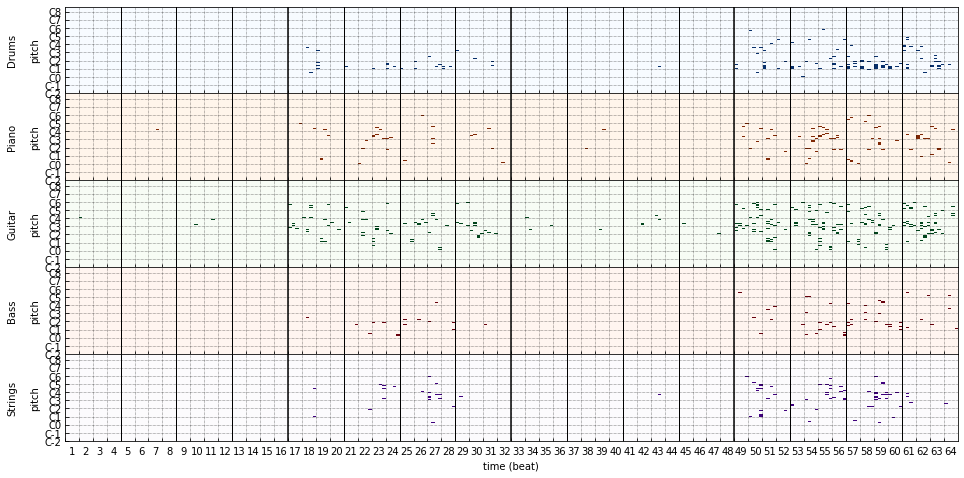

Step=1000


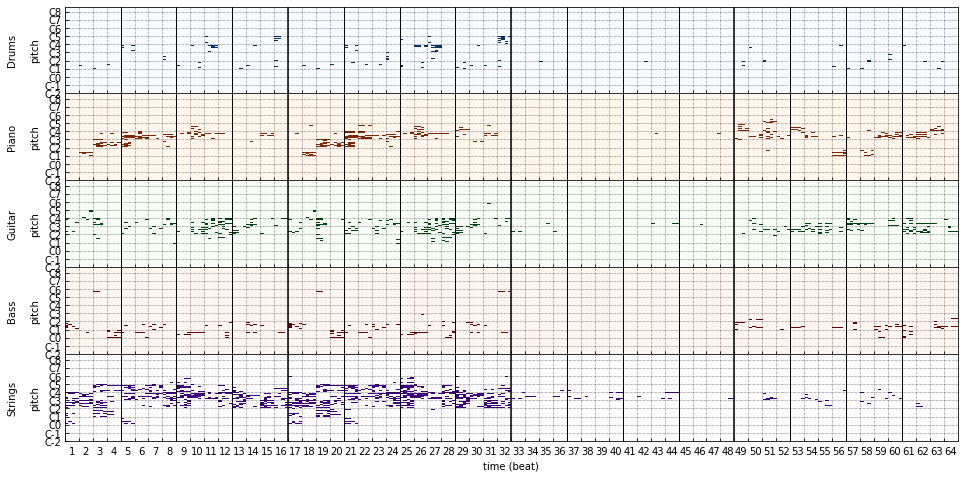

Step=10000


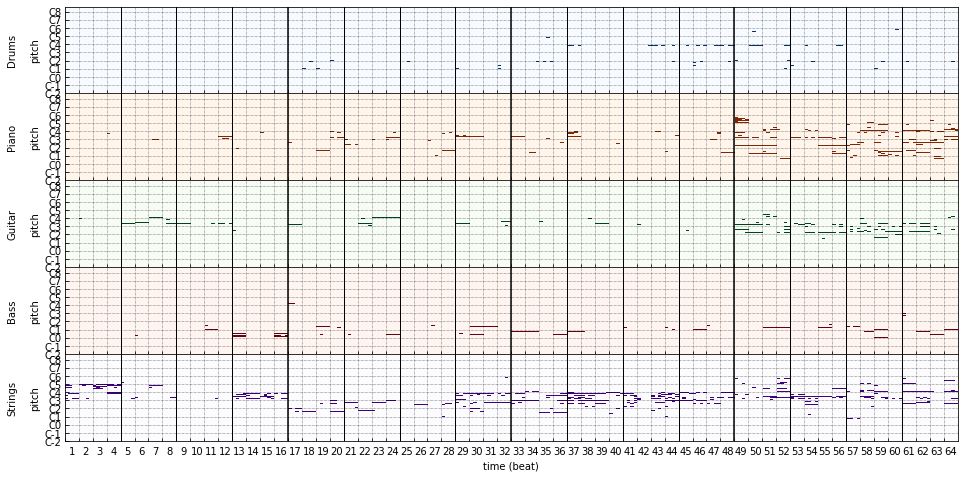

Step=20000


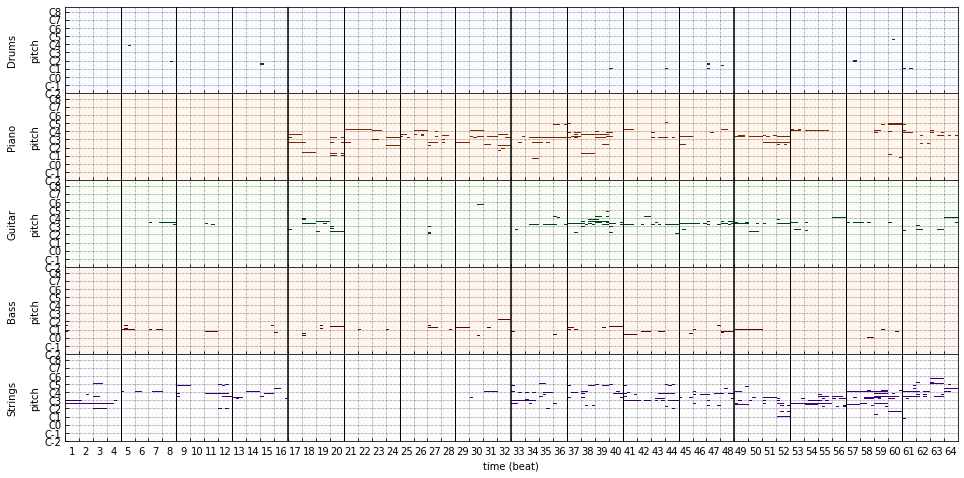

In [31]:
# Show history
steps = [0, sample_interval, 10 * sample_interval, 100 * sample_interval, n_steps]
for step in steps:
    print(f"Step={step}")
    samples = history_samples[step].transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
        )
        tracks.append(
            Track(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll,
            )
        )
    m = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
    axs = m.plot()
    for ax in axs:
        for x in range(
            measure_resolution,
            4 * measure_resolution * n_measures,
            measure_resolution
        ):
            if x % (measure_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((16, 8))
    plt.show()

In [32]:
import torch
dict_to_save = {
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'generator_optimizer': g_optimizer.state_dict(),
    'discriminator_optimizer': d_optimizer.state_dict()
}

In [33]:
torch.save(dict_to_save, "newmodel.pth")

In [34]:
##### Inference

In [18]:
import torch
# Load the saved state dictionaries
loaded_dict = torch.load("newmodel_0.pth")

# Access the individual components
generator_state_dict = loaded_dict['generator']
discriminator_state_dict = loaded_dict['discriminator']
g_optimizer_state_dict = loaded_dict['generator_optimizer']
d_optimizer_state_dict = loaded_dict['discriminator_optimizer']

# Assuming you have already created the generator, discriminator, and optimizers
discriminator = Discriminator()
generator = Generator()

d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Assign the loaded state dictionaries to their corresponding objects
generator.load_state_dict(generator_state_dict)
discriminator.load_state_dict(discriminator_state_dict)
g_optimizer.load_state_dict(g_optimizer_state_dict)
d_optimizer.load_state_dict(d_optimizer_state_dict)

In [19]:
latent_dim = 128
n_samples = 1
sample_latent = torch.randn(n_samples, latent_dim)
generator.eval()
samples = generator(sample_latent).cpu().detach().numpy()
# history_samples[step] = samples


In [20]:
print("samples shape", samples.shape)

samples shape (1, 5, 64, 72)


In [21]:
# display generated samples
samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
tracks = []
for idx, (program, is_drum, track_name) in enumerate(
    zip(programs, is_drums, track_names)
):
    pianoroll = np.pad(
        samples[idx] > 0.5,
        ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
    )
    tracks.append(
        Track(
            name=track_name,
            program=program,
            is_drum=is_drum,
            pianoroll=pianoroll
        )
    )

In [30]:
import pypianoroll


# beat_timings = [0.0, 1.0, 2.0, 3.0]

m = pypianoroll.Multitrack(
    tracks=tracks,
    tempo=np.array([100]),
    beat_resolution=beat_resolution,
#     beat_times=beat_timings
)
# axs = m.plot()
# plt.gcf().set_size_inches((16, 8))
# for ax in axs:
#     for x in range(
#         measure_resolution,
#         4 * measure_resolution * n_measures,
#         measure_resolution
#     ):
#         if x % (measure_resolution * 4) == 0:
#             ax.axvline(x - 0.5, color='k')
#         else:
#             ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
# plt.show()

In [31]:
m.save('yobaba.mid')

In [30]:
pip install pretty_midi

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [33]:
!pip show pypianoroll

Name: pypianoroll
Version: 0.5.3
Summary: A python package for handling multitrack pianorolls.
Home-page: https://github.com/salu133445/pypianoroll
Author: Hao-Wen Dong
Author-email: salu.hwdong@gmail.com
License: UNKNOWN
Location: /home/jjhaveri/.local/lib/python3.9/site-packages
Requires: six, pretty-midi, numpy, scipy
Required-by: 


In [32]:
import pypianoroll

output_file = 'output_new_0_100.mid'  # Specify the output file path

m.write(output_file + '.npz')  # Save as .npz file

track = pypianoroll.Multitrack(output_file + '.npz.mid')  # Load the .npz file

track.write(output_file)  # Convert .npz to .mid file


FileNotFoundError: [Errno 2] No such file or directory: 'yobaba.mid.npz.mid'

In [23]:
!pip show pypianoroll

Name: pypianoroll
Version: 0.5.3
Summary: A python package for handling multitrack pianorolls.
Home-page: https://github.com/salu133445/pypianoroll
Author: Hao-Wen Dong
Author-email: salu.hwdong@gmail.com
License: UNKNOWN
Location: /home/jjhaveri/.local/lib/python3.9/site-packages
Requires: numpy, scipy, six, pretty-midi
Required-by: 


In [16]:
# pm.estimate_beat_start()

NameError: name 'pm' is not defined

In [12]:
import torch
import pypianoroll

for i in range(4000,12000,8000):
    for j in range(5):
        # Load the saved state dictionaries
        loaded_dict = torch.load("newmodel_"+str(i)+".pth")
        print("newmodel"+str(i)+".pth")
        # Access the individual components
        generator_state_dict = loaded_dict['generator']
        discriminator_state_dict = loaded_dict['discriminator']
        g_optimizer_state_dict = loaded_dict['generator_optimizer']
        d_optimizer_state_dict = loaded_dict['discriminator_optimizer']

        # Assuming you have already created the generator, discriminator, and optimizers
        discriminator = Discriminator()
        generator = Generator()

        d_optimizer = torch.optim.Adam(
            discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
        g_optimizer = torch.optim.Adam(
            generator.parameters(), lr=0.001, betas=(0.5, 0.9))

        # Assign the loaded state dictionaries to their corresponding objects
        generator.load_state_dict(generator_state_dict)
        discriminator.load_state_dict(discriminator_state_dict)
        g_optimizer.load_state_dict(g_optimizer_state_dict)
        d_optimizer.load_state_dict(d_optimizer_state_dict)

        latent_dim = 128
        n_samples = 1
        sample_latent = torch.randn(n_samples, latent_dim)
        generator.eval()
        samples = generator(sample_latent).cpu().detach().numpy()
        # history_samples[step] = samples

        # display generated samples
        samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
        tracks = []

        for idx, (program, is_drum, track_name) in enumerate(
            zip(programs, is_drums, track_names)
        ):
            pianoroll = np.pad(
                samples[idx] > 0.5,
                ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
            )
            tracks.append(
                Track(
                    name=track_name,
                    program=program,
                    is_drum=is_drum,
                    pianoroll=pianoroll
                )
            )
        for k in range(80,120,20):
            m = pypianoroll.Multitrack(
                tracks=tracks,
                tempo=np.array([k]),
                beat_resolution=beat_resolution
            )

            output_file = 'output_'+str(i)+"take"+str(j)+"_beat_"+str(k)+'.mid'  # Specify the output file path

            m.write(output_file + '.npz')  # Save as .npz file

            track = pypianoroll.Multitrack(output_file + '.npz.mid')  # Load the .npz file

            track.write(output_file)  # Convert .npz to .mid file


newmodel4000.pth
newmodel4000.pth
newmodel4000.pth
newmodel4000.pth
newmodel4000.pth
